# 12. Non-parametric Estimation and Testing

## [Inference Theory 1](https://lamastex.github.io/scalable-data-science/infty/2018/01/)

&copy;2018 Raazesh Sainudiin. [Attribution 4.0 International (CC BY 4.0)](https://creativecommons.org/licenses/by/4.0/)

### Topics

- Non-parametric Estimation
- Glivenko-Cantelli Theorem
- Dvoretsky-Kiefer-Wolfowitz Inequality
- Hypothesis Testing
- Permutation Testing
- Permutation Testing with Shells Data
  

## Inference and Estimation: The Big Picture

The Big Picture is about inference and estimation, and especially inference and estimation problems where computational techniques are helpful. 

<table border="1" cellspacing="2" cellpadding="2" align="center">
<tbody>
<tr>
<td style="background-color: #ccccff;" align="center">&nbsp;</td>
<td style="background-color: #ccccff;" align="center"><strong>Point estimation</strong></td>
<td style="background-color: #ccccff;" align="center"><strong>Set estimation</strong></td>
</tr>
<tr>
<td style="background-color: #ccccff;">
<p><strong>Parametric</strong></p>
<p>&nbsp;</p>
</td>
<td style="background-color: #ccccff;" align="center">
<p>MLE of finitely many parameters<br /><span style="color: #3366ff;"><em>done</em></span></p>
</td>
<td style="background-color: #ccccff;" align="center">
<p>Confidence intervals,<br /> via the central limit theorem</p>
</td>
</tr>
<tr>
<td style="background-color: #ccccff;">
<p><strong>Non-parametric</strong><br /> (infinite-dimensional parameter space)</p>
</td>
<td style="background-color: #ccccff;" align="center"><strong><em><span style="color: #3366ff;">about to see ... </span></em></strong></td>
<td style="background-color: #ccccff;" align="center"><strong><em><span style="color: #3366ff;">about to see ... </span></em></strong></td>
</tr>
<tr>
<td style="background-color: #ccccff;">
<p><strong>One/Many-dimensional Integrals</strong><br /> (finite-dimensional)</p>
</td>
<td style="background-color: #ccccff;" align="center"><em><span style="color: #3366ff;">coming up ... </span></em></td>
<td style="background-color: #ccccff;" align="center">&nbsp;<span style="color: #3366ff;"><em>coming up ...</em></span></td>
</tr>
</tbody>
</table>

So far we have seen parametric models, for example

- $X_1, X_2, \ldots, X_n \overset{IID}{\sim} Bernoulli (\theta)$, $\theta \in [0,1]$
- $X_1, X_2, \ldots, X_n \overset{IID}{\sim} Exponential (\lambda)$, $\lambda \in (0,\infty)$
- $X_1, X_2, \ldots, X_n \overset{IID}{\sim} Normal(\mu^*, \sigma)$, $\mu \in \mathbb{R}$, $\sigma \in (0,\infty)$

In all these cases **the parameter space** (the space within which the parameter(s) can take values) is **finite dimensional**:

- for the $Bernoulli$, $\theta \in [0,1] \subseteq \mathbb{R}^1$
- for the $Exponential$, $\lambda \in (0, \infty) \subseteq \mathbb{R}^1$
- for the $Normal$, $\mu \in \mathbb{R}^1$, $\sigma \in (0,\infty) \subseteq \mathbb{R}^1$, so $(\mu, \sigma) \subseteq \mathbb{R}^2$

For parametric experiments, we can use the maximum likelihood principle and estimate the parameters using the **Maximum Likelihood Estimator (MLE)**, for instance. 

# Non-parametric estimation

Suppose we don't know what the distribution function (DF) is?  We are not trying to estimate some fixed but unknown parameter $\theta^*$ for some RV we are assuming to be $Bernoulli(\theta^*)$, we are trying to estimate the DF itself.  In real life, data does not come neatly labeled "I am a realisation of a $Bernoulli$ RV", or "I am a realisation of an $Exponential$ RV": an important part of inference and estimation is to make inferences about the DF itself from our observations.   

#### Observations from some unknown process
<img src="images/unknownProcessTimesAnim.gif" width=400>

Consider the following non-parametric product experiment:

$$X_1, X_2, \ldots, X_n\ \overset{IID}{\sim} F^* \in \{\text{all DFs}\}$$

We want to produce a point estimate for $F^*$, which is a allowed to be any DF ("lives in the set of all DFs"), i.e., $F^* \in \{\text{all DFs}\}$

Crucially, $\{\text{all DFs}\}$, i.e., the set of all distribution functions over $\mathbb{R}$ is infinite dimensional.

<img src="images/TwoDFs.png" width=400>

We have already seen an estimate, made using the data, of a distribution function:  the empirical or data-based distribution function (or empirical cumulative distribution function). This can be formalized as the following process of adding indicator functions of the half-lines beginning at the data points $[X_1,+\infty),[X_2,+\infty),\ldots,[X_n,+\infty)$:

$$\widehat{F}_n (x) = \frac{1}{n} \sum_{i=1}^n \mathbf{1}_{[X_i,+\infty)}(x)$$


where,

$$\mathbf{1}_{[X_i,+\infty)}(x) := \begin{cases} & 1 \quad \text{ if } X_i \leq x \\ & 0 \quad \text{ if }X_i > x \end{cases}$$


First let us evaluate a set of functions that will help us conceptualize faster:

In [1]:
def makeEMFHidden(myDataList):
    '''Make an empirical mass function from a data list.
    
    Param myDataList, list of data to make emf from.
    Return list of tuples comprising (data value, relative frequency) ordered by data value.'''
    
    sortedUniqueValues = sorted(list(set(myDataList)))
    freqs = [myDataList.count(i) for i in sortedUniqueValues]
    relFreqs = [ZZ(fr)/len(myDataList) for fr in freqs] # use a list comprehension
    
    return zip(sortedUniqueValues, relFreqs)
    

from pylab import array

def makeEDFHidden(myDataList, offset=0):
    '''Make an empirical distribution function from a data list.
    
    Param myDataList, list of data to make ecdf from.
    Param offset is an offset to adjust the edf by, used for doing confidence bands.
    Return list of tuples comprising (data value, cumulative relative frequency) ordered by data value.'''
    
    sortedUniqueValues = sorted(list(set(myDataList)))
    freqs = [myDataList.count(i) for i in sortedUniqueValues]
    from pylab import cumsum
    cumFreqs = list(cumsum(freqs)) #
    cumRelFreqs = [ZZ(i)/len(myDataList) for i in cumFreqs] # get cumulative relative frequencies as rationals
    if offset > 0: # an upper band
        cumRelFreqs = [min(i ,1) for i in cumRelFreqs] # use a list comprehension
    if offset < 0: # a lower band
        cumRelFreqs = [max(i, 0) for i in cumFreqs] # use a list comprehension
    return zip(sortedUniqueValues, cumRelFreqs)
    
# EPMF plot
def epmfPlot(samples):
    '''Returns an empirical probability mass function plot from samples data.'''
    
    epmf_pairs = makeEMFHidden(samples)
    epmf = point(epmf_pairs, rgbcolor = "blue", pointsize="20")
    for k in epmf_pairs:    # for each tuple in the list
        kkey, kheight = k     # unpack tuple
        epmf += line([(kkey, 0),(kkey, kheight)], rgbcolor="blue", linestyle=":")
    # padding
    epmf += point((0,1), rgbcolor="black", pointsize="0")
    return epmf
    

# ECDF plot
def ecdfPlot(samples):
    '''Returns an empirical probability mass function plot from samples data.'''
    ecdf_pairs = makeEDFHidden(samples)
    ecdf = point(ecdf_pairs, rgbcolor = "red", faceted = false, pointsize="20")
    for k in range(len(ecdf_pairs)):
        x, kheight = ecdf_pairs[k]     # unpack tuple
        previous_x = 0
        previous_height = 0
        if k > 0:
            previous_x, previous_height = ecdf_pairs[k-1] # unpack previous tuple
        ecdf += line([(previous_x, previous_height),(x, previous_height)], rgbcolor="grey")
        ecdf += points((x, previous_height),rgbcolor = "white", faceted = true, pointsize="20")
        ecdf += line([(x, previous_height),(x, kheight)], rgbcolor="grey", linestyle=":")
    # padding
    ecdf += line([(ecdf_pairs[0][0]-0.2, 0),(ecdf_pairs[0][0], 0)], rgbcolor="grey")
    max_index = len(ecdf_pairs)-1
    ecdf += line([(ecdf_pairs[max_index][0], ecdf_pairs[max_index][1]),(ecdf_pairs[max_index][0]+0.2, ecdf_pairs[max_index][1])],rgbcolor="grey")
    return ecdf
    
def calcEpsilon(alphaE, nE):
    '''Return confidence band epsilon calculated from parameters alphaE > 0 and nE > 0.'''
    
    return sqrt(1/(2*nE)*log(2/alphaE))

### Let us continue with the concepts

We can remind ourselves of this for a small sample of $de\,Moivre(k=5)$ RVs:

In [2]:
deMs=[randint(1,5) for i in range(20)]  # randint can be used to uniformly sample integers in a specified range
deMs

[2, 5, 4, 3, 2, 4, 4, 3, 3, 2, 2, 4, 3, 1, 2, 3, 1, 2, 1, 5]

In [3]:
sortedUniqueValues = sorted(list(set(deMs)))
freqs = [deMs.count(i) for i in sortedUniqueValues]
from pylab import cumsum
cumFreqs = list(cumsum(freqs)) #
cumRelFreqs = [ZZ(i)/len(deMs) for i in cumFreqs] # get cumulative relative frequencies as rationals
zip(sortedUniqueValues, cumRelFreqs)

[(1, 3/20), (2, 9/20), (3, 7/10), (4, 9/10), (5, 1)]

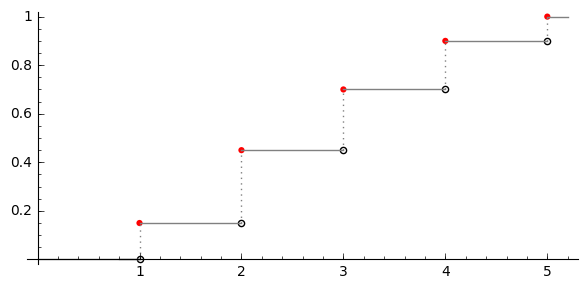

In [4]:
show(ecdfPlot(deMs), figsize=[6,3]) # use hidden ecdfPlot function to plot

We can use the empirical cumulative distribution function $\widehat{F}_n$ for our non-parametric estimate because this kind of estimation is possible in infinite-dimensional contexts due to the following two theorems:

- Glivenko-Cantelli Theorem (*Fundamental Theorem of Statistics*)
- Dvoretsky-Kiefer-Wolfowitz (DKW) Inequality

# Glivenko-Cantelli Theorem

Let $X_1, X_2, \ldots, X_n \overset{IID}{\sim} F^* \in \{\text{all DFs}\}$

and the empirical distribution function (EDF) is $\widehat{F}_n(x) := \displaystyle\frac{1}{n} \sum_{i=1}^n \mathbf{1}_{[X_i,+\infty)}(x)$, then

$$\sup_x { | \widehat{F}_n(x) - F^*(x) | } \overset{P}{\rightarrow} 0$$

Remember that the EDF is a statistic of the data, a statistic is an RV, and (from our work the convergence of random variables), $\overset{P}{\rightarrow}$ means "converges in probability".  The proof is beyond the scope of this course, but we can gain an appreciation of what it means by looking at what happens to the ECDF for $n$ simulations from:

- $de\,Moivre(1/5,1/5,1/5,1/5,1/5)$ and  
- $Uniform(0,1)$ as $n$ increases:

In [5]:
@interact
def _(n=(10,(0..200))):
    '''Interactive function to plot ecdf for obs from de Moirve (5).'''
    if (n > 0):
        us = [randint(1,5) for i in range(n)]
        p=ecdfPlot(us) # use hidden ecdfPlot function to plot
        #p+=line([(-0.2,0),(0,0),(1,1),(1.2,1)],linestyle=':')
        p.show(figsize=[8,2])

In [6]:
@interact
def _(n=(10,(0..200))):
    '''Interactive function to plot ecdf for obs from Uniform(0,1).'''
    if (n > 0):
        us = [random() for i in range(n)]
        p=ecdfPlot(us) # use hidden ecdfPlot function to plot
        p+=line([(-0.2,0),(0,0),(1,1),(1.2,1)],linestyle='-')
        p.show(figsize=[3,3],aspect_ratio=1)

It is clear, that as $n$ increases, the ECDF $\widehat{F}_n$ gets closer and closer to the true DF $F^*$,   $\displaystyle\sup_x { | \widehat{F}_n(x) - F^*(x) | } \overset{P}{\rightarrow} 0$.

This will hold no matter what the (possibly unknown) $F^*$ is.  Thus, $\widehat{F}_n$ is a point estimate of $F^*$.

We need to add the DKW Inequality be able to get confidence sets or a 'confidence band' that traps $F^*$ with high probability.

# Dvoretsky-Kiefer-Wolfowitz (DKW) Inequality

Let $X_1, X_2, \ldots, X_n \overset{IID}{\sim} F^* \in \{\text{all DFs}\}$

and the empirical distribution function (EDF) is $\widehat{F}_n(x) := \displaystyle\frac{1}{n} \sum_{i=1}^n \mathbf{1}_{[X_i,+\infty)}(x)$,

then, for any $\varepsilon > 0$,

$$P\left( \sup_x { | \widehat{F}_n(x) - F^*(x) | > \varepsilon  }\right) \leq 2 \exp(-2n\varepsilon^2) $$

We can use this inequality to get a $1-\alpha$ confidence band $C_n(x) := \left[\underline{C}_n(x), \overline{C}_n(x)\right]$ about our point estimate $\widehat{F}_n$ of our possibly unknown $F^*$ such that the $F^*$ is 'trapped' by the band with probability at least $1-\varepsilon$.

$$\begin{eqnarray} \underline{C}_{\, n}(x) &=& \max \{ \widehat{F}_n(x)-\varepsilon_n, 0 \}, \notag \\ \overline{C}_{\, n}(x) &=& \min \{ \widehat{F}_n(x)+\varepsilon_n, 1 \}, \notag \\ \varepsilon_n &=& \sqrt{ \frac{1}{2n} \log \left( \frac{2}{\alpha}\right)} \\ \end{eqnarray}$$

and

$$P\left(\underline{C}_n(x) \leq F^*(x) \leq \overline{C}_n(x)\right) \geq 1-\alpha$$

 

### YouTry in class

Try this out for a simple sample from the $Uniform(0,1)$, which you can generate using random.   First we  will just make the point estimate for $F^*$, the EDF $\widehat{F}_n$

In [14]:
n=10
uniformSample = [random() for i in range(n)]
print(uniformSample)

[0.9227376690483293, 0.6668806908011303, 0.2564801114531464, 0.9285926813657961, 0.8902807255510499, 0.7332617774638567, 0.6087392170413539, 0.003998737606123015, 0.7153968950599606, 0.47146970843132696]


In one of the assessments, you did a question that took you through the steps for getting the list of points that you would plot for an empirical  distribution function (EDF).  We will do exactly the same thing here.

First we find the unique values in the sample, in order from smallest to largest, and get the frequency with which each unique value occurs:

In [15]:
sortedUniqueValuesUniform = sorted(list(set(uniformSample)))
print(sortedUniqueValuesUniform)

[0.003998737606123015, 0.2564801114531464, 0.47146970843132696, 0.6087392170413539, 0.6668806908011303, 0.7153968950599606, 0.7332617774638567, 0.8902807255510499, 0.9227376690483293, 0.9285926813657961]


In [16]:
freqsUniform = [uniformSample.count(i) for i in sortedUniqueValuesUniform]
freqsUniform

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

Then we accumulate the frequences to get the cumulative frequencies:

In [17]:
from pylab import cumsum
cumFreqsUniform = list(cumsum(freqsUniform)) # accumulate
cumFreqsUniform

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

And the the relative cumlative frequencies:

In [18]:
# cumulative rel freqs as rationals
cumRelFreqsUniform = [ZZ(i)/len(uniformSample) for i in cumFreqsUniform] 
cumRelFreqsUniform

[1/10, 1/5, 3/10, 2/5, 1/2, 3/5, 7/10, 4/5, 9/10, 1]

And finally zip these up with the sorted unique values to get a list of points we can plot:

In [19]:
ecdfPointsUniform = zip(sortedUniqueValuesUniform, cumRelFreqsUniform)
ecdfPointsUniform

[(0.003998737606123015, 1/10),
 (0.2564801114531464, 1/5),
 (0.47146970843132696, 3/10),
 (0.6087392170413539, 2/5),
 (0.6668806908011303, 1/2),
 (0.7153968950599606, 3/5),
 (0.7332617774638567, 7/10),
 (0.8902807255510499, 4/5),
 (0.9227376690483293, 9/10),
 (0.9285926813657961, 1)]

Here is a function that you can just use to do a ECDF plot:

In [20]:
# ECDF plot given a list of points to plot
def ecdfPointsPlot(listOfPoints, colour='grey', lines_only=False):
    '''Returns an empirical probability mass function plot from a list of points to plot.
    
    Param listOfPoints is the list of points to plot.
    Param colour is used for plotting the lines, defaulting to grey.
    Param lines_only controls wether only lines are plotted (true) or points are added (false, the default value).
    Returns an ecdf plot graphic.'''
    
    ecdfP = point((0,0), pointsize="0")
    if not lines_only: ecdfP = point(listOfPoints, rgbcolor = "red", faceted = false, pointsize="20")
    for k in range(len(listOfPoints)):
        x, kheight = listOfPoints[k]     # unpack tuple
        previous_x = 0
        previous_height = 0
        if k > 0:
            previous_x, previous_height = listOfPoints[k-1] # unpack previous tuple
        ecdfP += line([(previous_x, previous_height),(x, previous_height)], rgbcolor=colour)
        ecdfP += line([(x, previous_height),(x, kheight)], rgbcolor=colour, linestyle=":")
        if not lines_only: 
            ecdfP += points((x, previous_height),rgbcolor = "white", faceted = true, pointsize="20")
            # padding
    max_index = len(listOfPoints)-1
    ecdfP += line([(listOfPoints[0][0]-0.2, 0),(listOfPoints[0][0], 0)], rgbcolor=colour)
    ecdfP += line([(listOfPoints[max_index][0], listOfPoints[max_index][1]),(listOfPoints[max_index][0]+0.2, listOfPoints[max_index][1])],rgbcolor=colour)
    return ecdfP

This makes the plot of the $\widehat{F}_{10}$, the point estimate for $F^*$ for these $n=10$ simulated samples.

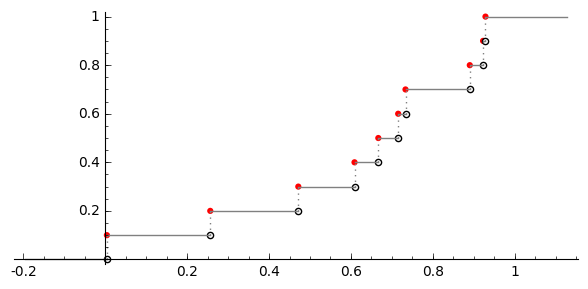

In [21]:
show(ecdfPointsPlot(ecdfPointsUniform), figsize=[6,3])

What about adding those confidence bands?  You will do essentially the same thing, but adjusting for the required $\varepsilon$.  First we need to decide on an $\alpha$ and calculate the $\varepsilon$ corresponding to this alpha.  Here is some of our code to calculate the $\varepsilon$ corresponding to $\alpha=0.05$ (95% confidence bands), using a hidden function calcEpsilon:  

In [22]:
alpha = 0.05
epsilon = calcEpsilon(alpha, n)
epsilon

0.429469408346738

See if you can write your own code to do this calculation, $\varepsilon_n = \sqrt{ \frac{1}{2n} \log \left( \frac{2}{\alpha}\right)}$. For completeness, do the whole thing:assign the value 0.05 to a variable named alpha, and then use this and the variable called n that we have already declared to calculate a value for $\varepsilon$.  Call the variable to which you assign the value for $\varepsilon$  epsilon so that it replaces the value we calculated in the cell above (you should get the same value as us!).

Now we need to use this to adjust the EDF plot.  In the two cells below we first of all do the adjustment for $\underline{C}_{\,n}(x) =\max \{ \widehat{F}_n(x)-\varepsilon_n, 0 \}$, and then use zip again to get the points to actually plot for the lower boundary of the 95% confidence band.

Now we need to use this to adjust the EDF plot. In the two cells below we first of all do the adjustment for $\overline{C}_{\,n}(x) =\min \{ \widehat{F}_n(x)+\varepsilon_n, 1 \}$, and then use zip again to get the points to actually plot for the lower boundary of the 95% confidence band.

In [23]:
# heights for the lower band
cumRelFreqsUniformLower = [max(crf - epsilon, 0) for crf in cumRelFreqsUniform] 
print(cumRelFreqsUniformLower)

[0, 0, 0, 0, 0.0705305916532624, 0.170530591653262, 0.270530591653262, 0.370530591653262, 0.470530591653262, 0.570530591653262]


In [24]:
ecdfPointsUniformLower = zip(sortedUniqueValuesUniform, cumRelFreqsUniformLower)
ecdfPointsUniformLower

[(0.003998737606123015, 0),
 (0.2564801114531464, 0),
 (0.47146970843132696, 0),
 (0.6087392170413539, 0),
 (0.6668806908011303, 0.0705305916532624),
 (0.7153968950599606, 0.170530591653262),
 (0.7332617774638567, 0.270530591653262),
 (0.8902807255510499, 0.370530591653262),
 (0.9227376690483293, 0.470530591653262),
 (0.9285926813657961, 0.570530591653262)]

We carefully gave our `ecdfPointsPlo`t function the flexibility to be able to plot bands, by having a colour parameter (which defaults to 'grey') and a `lines_only` parameter (which defaults to `false`).  Here we can plot the lower bound of the confidence interval by adding `ecdfPointsPlot(ecdfPointsUniformLower, colour='green', lines_only=true)` to the previous plot:

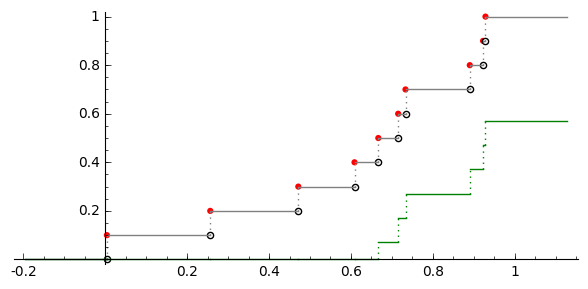

In [25]:
pointEstimate = ecdfPointsPlot(ecdfPointsUniform)
lowerBound = ecdfPointsPlot(ecdfPointsUniformLower, colour='green', lines_only=true)
show(pointEstimate + lowerBound, figsize=[6,3])

### YouTry 
You try writing the code to create the list of points needed for plotting the upper band $\overline{C}_{\,n}(x) =\min \{ \widehat{F}_n(x)+\varepsilon_n, 1 \}$.  You will need to first of all get the upper heights (call them say `cumRelFreqsUniformUpper`) and then `zip` them up with the `sortedUniqueValuesUniform` to get the points to plot.

In [ ]:
# heights for the upper band


Once you have got done this you can add them to the plot by altering the code below:

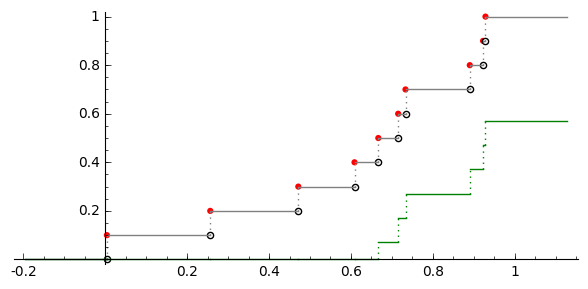

In [26]:
pointEstimate = ecdfPointsPlot(ecdfPointsUniform)
lowerBound = ecdfPointsPlot(ecdfPointsUniformLower,colour='green', lines_only=true)
show(pointEstimate + lowerBound, figsize=[6,3])

(end of YouTry)

---

If we are doing lots of collections of EDF points we may as well define a function to do it, rather than repeating the same code again and again.  We use an offset parameter to give us the flexibility to use this to make points for confidence bands as well.

In [27]:
def makeEDFPoints(myDataList, offset=0):
    '''Make a list empirical distribution plotting points from from a data list.
    
    Param myDataList, list of data to make ecdf from.
    Param offset is an offset to adjust the edf by, used for doing confidence bands.
    Return list of tuples comprising (data value, cumulative relative frequency(with offset)) ordered by data value.'''
    
    sortedUniqueValues = sorted(list(set(myDataList)))
    freqs = [myDataList.count(i) for i in sortedUniqueValues]
    from pylab import cumsum
    cumFreqs = list(cumsum(freqs)) 
    cumRelFreqs = [ZZ(i)/len(myDataList) for i in cumFreqs] # get cumulative relative frequencies as rationals
    if offset > 0: # an upper band
        cumRelFreqs = [min(i+offset ,1) for i in cumRelFreqs]
    if offset < 0: # a lower band
        cumRelFreqs = [max(i+offset, 0) for i in cumRelFreqs] 
    return zip(sortedUniqueValues, cumRelFreqs)

## NZ EartQuakes

Now we will try looking at the Earthquakes data we have used before to get a confidence band around an EDF for that.  We start by bringing in the data and the function we wrote earlier to parse that data.

In [29]:
def getLonLatMagDepTimes(NZEQCsvFileName):
    '''returns longitude, latitude, magnitude, depth and the origin time as unix time
    for each observed earthquake in the csv filr named NZEQCsvFileName'''
    from datetime import datetime
    import time
    from dateutil.parser import parse
    import numpy as np
    
    with open(NZEQCsvFileName) as f:
        reader = f.read() 
        dataList = reader.split('\n')
        
    myDataAccumulatorList =[]
    for data in dataList[1:-1]:
        dataRow = data.split(',')
        myTimeString = dataRow[2] # origintime
        # let's also grab longitude, latitude, magnitude, depth
        myDataString = [dataRow[4],dataRow[5],dataRow[6],dataRow[7]]
        try: 
            myTypedTime = time.mktime(parse(myTimeString).timetuple())
            myFloatData = [float(x) for x in myDataString]
            myFloatData.append(myTypedTime) # append the processed timestamp
            myDataAccumulatorList.append(myFloatData)
        except TypeError, e: # error handling for type incompatibilities
            print 'Error:  Error is ', e
    #return np.array(myDataAccumulatorList)
    return myDataAccumulatorList

myProcessedList = getLonLatMagDepTimes('data/earthquakes.csv')

def interQuakeTimes(quakeTimes):
    '''Return a list inter-earthquake times in seconds from earthquake origin times
    Date and time elements are expected to be in the 5th column of the array
    Return a list of inter-quake times in seconds. NEEDS sorted quakeTimes Data'''
    import numpy as np
    retList = []
    if len(quakeTimes) > 1:
        retList = [quakeTimes[i]-quakeTimes[i-1] for i in range(1,len(quakeTimes))]
    #return np.array(retList)
    return retList

interQuakesSecs = interQuakeTimes(sorted([x[4] for x in myProcessedList]))
len(interQuakesSecs)

21015

In [30]:
interQuakesSecs[0:10]

[531.0, 551.0, 764.0, 294.0, 678.0, 1538.0, 376.0, 364.0, 208.0, 242.0]

There is a lot of data here, so let's use an interactive plot to do the non-parametric DF estimation just for some of the last data:

In [31]:
@interact
def _(takeLast=(500,(0..min(len(interQuakesSecs),1999))), alpha=(0.05)):
    '''Interactive function to plot the edf estimate and confidence bands for inter earthquake times.'''
    if takeLast > 0 and alpha > 0 and alpha < 1:
        lastInterQuakesSecs = interQuakesSecs[len(interQuakesSecs)-takeLast:len(interQuakesSecs)]
        interQuakePoints = makeEDFPoints(lastInterQuakesSecs)
        p=ecdfPointsPlot(interQuakePoints, lines_only=true)
        epQuakes = calcEpsilon(alpha, len(lastInterQuakesSecs))
        interQuakePointsLower = makeEDFPoints(lastInterQuakesSecs, offset=-epQuakes)
        lowerQuakesBound = ecdfPointsPlot(interQuakePointsLower, colour='green', lines_only=true)
        interQuakePointsUpper = makeEDFPoints(lastInterQuakesSecs, offset=epQuakes)
        upperQuakesBound = ecdfPointsPlot(interQuakePointsUpper, colour='green', lines_only=true)
        show(p + lowerQuakesBound + upperQuakesBound, figsize=[6,3])
    else:
        print "check your input values"

What if we are not interested in estimating $F^*$ itself, but we are interested in scientificially investigating whether two distributions are the same.  For example, perhaps, whether the distribution of earthquake magnitudes was the same in April as it was in March.  Then, we should attempt to reject a falsifiable hypothesis ...

# Hypothesis Testing

A formal definition of hypothesis testing is beyond our current scope.  Here we will look in particular at a non-parametric hypothesis test called a permutation test.  First, a quick review:

The outcomes of a hypothesis test, in general, are:

<table border="1" cellspacing="2" cellpadding="2" align="center">
<tbody>
<tr>
<td align="center">'true state of nature'</td>
<td align="center"><strong>Do not reject $H_0$<br /></strong></td>
<td align="center"><strong>Reject $H_0$<br /></strong></td>
</tr>
<tr>
<td>
<p><strong>$H_0$ is true<br /></strong></p>
<p>&nbsp;</p>
</td>
<td align="center">
<p>OK<span style="color: #3366ff;">&nbsp;</span></p>
</td>
<td align="center">
<p>Type I error</p>
</td>
</tr>
<tr>
<td>
<p><strong>$H_0$ is false</strong></p>
</td>
<td align="center">Type II error</td>
<td align="center">OK</td>
</tr>
</tbody>
</table>

So, we want a small probability that we reject  $H_0$ when $H_0$ is true (minimise Type I error).  Similarly, we want to minimise the probability that we fail to reject $H_0$ when $H_0$ is false (type II error). 

The P-value is one way to conduct a desirable hypothesis test.  The scale of the evidence against $H_0$ is stated in terms of the P-value.  The following interpretation of P-values is commonly used:

- P-value $\in (0, 0.01]$: Very strong evidence against $H_0$
- P-value $\in (0.01, 0.05]$: Strong evidence against $H_0$
- P-value $\in (0.05, 0.1]$: Weak evidence against $H_0$
- P-value $\in (0.1, 1]$: Little or no evidence against $H_0$

## Permutation Testing

A Permuation Test is a **non-parametric exact** method for testing whether two distributions are the same based on samples from each of them.

What do we mean by "non-parametric exact"?  It is non-parametric because we do not impose any parametric assumptions.  It is exact because it works for any sample size.

Formally, we suppose that: 
$$ X_1,X_2,\ldots,X_m \overset{IID}{\sim} F^* \quad \text{and} \quad X_{m+1}, X_{m+2},\ldots,X_{m+n} \overset{IID}{\sim} G^* \enspace , $$
are two sets of independent samples where the possibly unknown DFs 
$F^*,\,G^* \in \{ \text{all DFs} \}$.

(Notice that we have written it so that the subscripts on the $X$s run from 1 to $m+n$.)

Now, consider the following hypothesis test: 
$$H_0: F^*=G^* \quad \text{versus} \quad H_1: F^* \neq G^* \enspace . $$

Our test statistic uses the observations in both both samples.  We want a test statistic that is a sensible one for the test, i.e., will be large when when $F^*$ is 'too different' from $G^*$

So, let our test statistic $T(X_1,\ldots,X_m,X_{m+1},\ldots,X_{m+n})$ be say: 
$$
T:=T(X_1,\ldots,X_m,X_{m+1},\ldots,X_{m+n})= \text{abs} \left( \frac{1}{m} \sum_{i=1}^m X_i - \frac{1}{n} \sum_{i=m+1}^n X_i \right) \enspace .
$$

(In words, we have chosen a test statistic that is the absolute value of the difference in the sample means.   Note the limitation of this:  if $F^*$ and $G^*$ have the same mean but different variances, our test statistic $T$ will not be large.)

Then the idea of a permutation test is as follows:

- Let $N:=m+n$ be the pooled sample size and consider all $N!$ permutations of the observed data $x_{obs}:=(x_1,x_2,\ldots,x_m,x_{m+1},x_{m+2},\ldots,x_{m+n})$.
- For each permutation of the data compute the statistic $T(\text{permuted data } x)$ and denote these $N!$ values of $T$ by $t_1,t_2,\ldots,t_{N!}$.
- Under $H_0: X_1,\ldots,X_m,X_{m+1},\ldots,X_{m+n} \overset{IID}{\sim}F^*=G^*$, each of the permutations of $x= (x_1,x_2,\ldots,x_m,x_{m+1},x_{m+2},\ldots,x_{m+n})$ has the same joint probability $\prod_{i=1}^{m+n} f(x_i)$, where $f(x_i)$ is the density function corresponding to $F^*=G^*$, $f(x_i)=dF(x_i)=dG(x_i)$. 
- Therefore, the transformation of the data by our statistic $T$ also has the same probability over the values of $T$, namely $\{t_1,t_2,\ldots,t_{N!}\}$. Let $\mathbf{P}_0$ be this permutation distribution under the null hypothesis. $\mathbf{P}_0$ is discrete and uniform over $\{t_1,t_2,\ldots,t_{N!}\}$. 
- Let $t_{obs} := T(x_{obs})$ be the observed value of the test statistic.
- Assuming we reject $H_0$ when $T$ is large, the P-value = $\mathbf{P}_0 \left( T \geq t_{obs} \right)$
- Saying that $\mathbf{P}_0$ is discrete and uniform over $\{t_1, t_2, \ldots, t_{N!}\}$ says that each possible permutation has an equal probabability of occuring (under the null hypothesis).  There are $N!$ possible permutations and so the probability of any individual permutation is $\frac{1}{N!}$

$$
\text{P-value} = \mathbf{P}_0 \left( T \geq t_{obs} \right) = \frac{1}{N!} \left( \sum_{j=1}^{N!} \mathbf{1} (t_j \geq t_{obs}) \right), \qquad \mathbf{1} (t_j \geq t_{obs}) = \begin{cases} 1 & \text{if } \quad t_j \geq t_{obs} \\ 0 & \text{otherwise} \end{cases}
$$

This will make more sense if we look at some real data. 

## Permutation Testing with Shell Data

In 2008, Guo Yaozong and Chen Shun collected data on the diameters of coarse venus shells from New Brighton beach for a course project.  They recorded the diameters for two samples of shells, one from each side of the New Brighton Pier.  The data is given in the following two cells.

In [35]:
leftSide = [52, 54, 60, 60, 54, 47, 57, 58, 61, 57, 50, 60, 60, 60, 62, 44, 55, 58, 55,\
            60, 59, 65, 59, 63, 51, 61, 62, 61, 60, 61, 65, 43, 59, 58, 67, 56, 64, 47,\
            64, 60, 55, 58, 41, 53, 61, 60, 49, 48, 47, 42, 50, 58, 48, 59, 55, 59, 50, \
            47, 47, 33, 51, 61, 61, 52, 62, 64, 64, 47, 58, 58, 61, 50, 55, 47, 39, 59,\
            64, 63, 63, 62, 64, 61, 50, 62, 61, 65, 62, 66, 60, 59, 58, 58, 60, 59, 61,\
            55, 55, 62, 51, 61, 49, 52, 59, 60, 66, 50, 59, 64, 64, 62, 60, 65, 44, 58, 63]

In [36]:
rightSide = [58, 54, 60, 55, 56, 44, 60, 52, 57, 58, 61, 66, 56, 59, 49, 48, 69, 66, 49,\
             72, 49, 50, 59, 59, 59, 66, 62, 44, 49, 40, 59, 55, 61, 51, 62, 52, 63, 39,\
             63, 52, 62, 49, 48, 65, 68, 45, 63, 58, 55, 56, 55, 57, 34, 64, 66, 54, 65,\
             61, 56, 57, 59, 58, 62, 58, 40, 43, 62, 59, 64, 64, 65, 65, 59, 64, 63, 65,\
             62, 61, 47, 59, 63, 44, 43, 59, 67, 64, 60, 62, 64, 65, 59, 55, 38, 57, 61,\
             52, 61, 61, 60, 34, 62, 64, 58, 39, 63, 47, 55, 54, 48, 60, 55, 60, 65, 41,\
             61, 59, 65, 50, 54, 60, 48, 51, 68, 52, 51, 61, 57, 49, 51, 62, 63, 59, 62,\
             54, 59, 46, 64, 49, 61]

In [38]:
len(leftSide), len(rightSide)

(115, 139)

$(115 + 139)!$ is a very big number.   Lets start small, and take a subselection of the shell data to demonstrate the permutation test concept:  the first two shells from the left of the pier and the first one from the right:

In [39]:
rightSub = [52, 54]
leftSub = [58]
totalSample = rightSub + leftSub
totalSample

[52, 54, 58]

So now we are testing the hypotheses

$$\begin{array}{lcl}H_0&:& X_1,X_2,X_3 \overset{IID}{\sim} F^*=G^* \\H_1&:&X_1, X_2 \overset{IID}{\sim} F^*, \,\,X_3 \overset{IID}{\sim} G^*, F^* \neq G^*\end{array}$$ 

With the test statistic
$$\begin{array}{lcl}T(X_1,X_2,X_3) &=& \text{abs} \left(\displaystyle\frac{1}{2}\displaystyle\sum_{i=1}^2X_i - \displaystyle\frac{1}{1}\displaystyle\sum_{i=2+1}^3X_i\right) \\ &=&\text{abs}\left(\displaystyle\frac{X_1+ X_2}{2} - \displaystyle\frac{X_3}{1}\right)\end{array}$$

Our observed data $x_{obs} = (x_1, x_2, x_3) = (52, 54, 58)$

and the realisation of the test statistic for this data is $t_{obs} = \text{abs}\left(\displaystyle\frac{52+54}{2} - \frac{58}{1}\right) = \text{abs}\left(53 - 58\right) = \text{abs}(-5) = 5$

Now we need to tabulate the permutations and their probabilities.  There are 3! = 6 possible permutataions of three items.  For larger samples, you could use the `factorial` function to calculate this:

In [40]:
factorial(3)

6

We said that under the null hypotheses (the samples have the same DF) each permutation is equally likely, so each permutation has probability $\displaystyle\frac{1}{6}$.

There is a way in Python (the language under the hood in Sage), to get all the permuations of a sequence:

In [42]:
list(Permutations(totalSample))

[[52, 54, 58],
 [52, 58, 54],
 [54, 52, 58],
 [54, 58, 52],
 [58, 52, 54],
 [58, 54, 52]]

We can tabulate the permuations, their probabilities, and the value of the test statistic that would be associated with that permutation:

<table border="1" cellpadding="5" align="center">
<tbody>
<tr>
<td style="text-align: center;">Permutation</td>
<td style="text-align: center;">$t$</td>
<td style="text-align: center;">$\mathbf{P}_0(T=t)$</td>
</tr>
<tr>
<td style="text-align: center;"> </td>
<td style="text-align: center;"> </td>
<td style="text-align: center;">Probability under Null</td>
</tr>
<tr>
<td style="text-align: center;">(52, 54, 58)</td>
<td style="text-align: center;">5</td>
<td style="text-align: center;">$\frac{1}{6}$</td>
</tr>
<tr>
<td style="text-align: center;">(52, 58, 54)</td>
<td style="text-align: center;">&nbsp;1</td>
<td style="text-align: center;">$\frac{1}{6}$</td>
</tr>
<tr>
<td style="text-align: center;">(54, 52, 58)</td>
<td style="text-align: center;">5</td>
<td style="text-align: center;">$\frac{1}{6}$</td>
</tr>
<tr>
<td style="text-align: center;">(54, 58, 52)</td>
<td style="text-align: center;">4</td>
<td style="text-align: center;">$\frac{1}{6}$</td>
</tr>
<tr>
<td style="text-align: center;">(58, 52, 54)</td>
<td style="text-align: center;">1</td>
<td style="text-align: center;">$\frac{1}{6}$</td>
</tr>
<tr>
<td style="text-align: center;">(58, 54, 52)</td>
<td style="text-align: center;">4</td>
<td style="text-align: center;">$\frac{1}{6}$</td>
</tr>
</tbody>
</table>

In [44]:
allPerms = list(Permutations(totalSample))
for p in allPerms:
    t = abs((p[0] + p[1])/2 - p[2]/1)
    print p, " has t = ", t

[52, 54, 58]  has t =  5
[52, 58, 54]  has t =  1
[54, 52, 58]  has t =  5
[54, 58, 52]  has t =  4
[58, 52, 54]  has t =  1
[58, 54, 52]  has t =  4


To calculate the P-value for our test statistic $t_{obs} = 5$, we need to look at how many permutations would give rise to test statistics that are at least as big, and add up their probabilities.

$$
\begin{array}{lcl}\text{P-value} &=& \mathbf{P}_0(T \geq t_{obs}) \\&=&\mathbf{P}_0(T \geq 5)\\&=&\frac{1}{6} + \frac {1}{6} \\&=&\frac{2}{6}\\ &=&\frac{1}{3} \\ &\approx & 0.333\end{array}
$$

We could write ourselves a little bit of code to do this in SageMath.  As you can see, we could easily improve this to make it more flexible so that we could use it for different numbers of samples, but it will do for now.

In [46]:
allPerms = list(Permutations(totalSample))
pProb = 1/len(allPerms)
pValue = 0
tobs = 5
for p in allPerms:
    t = abs((p[0] + p[1])/2 - p[2]/1)
    if t >= tobs:
        pValue = pValue + pProb
pValue

1/3

This means that there is little or no evidence against the null hypothesis (that the shell diameter observations are from the same DF).

### Pooled sample size

The lowest possible P-value for a pooled sample of size $N=m+n$ is $\displaystyle\frac{1}{N!}$.  Can you see why this is? 

So with our small sub-samples the smallest possible P-value would be $\frac{1}{6} \approx 0.167$.  If we are looking for P-value $\leq 0.01$ to constitute very strong evidence against $H_0$, then we have to have a large enough pooled sample for this to be possible.  Since $5! = 5 \times 4 \times 3 \times 2 \times 1 = 120$, it is good to have $N \geq 5$

### YouTry in class

Try copying and pasting our code and then adapting it to deal with a sub-sample (52, 54, 60) from the left of the pier and (58, 54) from the right side of the pier.  

In [ ]:
rightSub = [52, 54, 60]
leftSub = [58, 54]
totalSample = rightSub + leftSub
totalSample

### You will have to think about:

- calculating the value of the test statistic for the observed data and for all the permuations of the total sample
- calculating the probability of each permutation
- calculating the P-value by adding the probabilities for the permutations with test statistics at least as large as the observed value of the test statistic

(add more cells if you need them)

(end of You Try)

---

We can use the sample function and the Python method for making permutations to experiment with a larger sample, say 5 of each.

In [47]:
n, m = 5, 5
leftSub = sample(leftSide, n)
rightSub = sample(rightSide,m)
totalSample = leftSub + rightSub
leftSub; rightSub; totalSample

[51, 55, 61, 50, 62, 52, 49, 59, 49, 59]

In [48]:
tobs = abs(mean(leftSub) - mean(rightSub))
tobs

11/5

We have met sample briefly already:  it is part of the Python random module and it does exactly what you would expect from the name: it samples a specified number of elements randomly from a sequence.

In [49]:
#define a helper function for calculating the tstat from a permutation
def tForPerm(perm, samplesize1, samplesize2):
    '''Calculates the t statistic for a permutation of data given the sample sizes to split the permuation into.
    
    Param perm is the permutation of data to be split into the two samples.
    Param samplesize1, samplesize2 are the two sample sizes.
    Returns the absolute value of the difference in the means of the two samples split out from perm.'''
    sample1 = [perm[i] for i in range(samplesize1)]
    sample2 = [perm[samplesize1+j] for j in range(samplesize2)]
    return abs(mean(sample1) - mean(sample2))

In [51]:
allPerms = list(Permutations(totalSample))
pProb = 1/len(allPerms)
pValue = 0
tobs = abs(mean(leftSub) - mean(rightSub))
for p in allPerms:
    t = tForPerm(p, n, m)
    if t >= tobs:
        pValue = pValue + pProb
pValue

23/42

In [52]:
n+m

10

In [53]:
factorial(n+m) # how many permutations is it checking

3628800

As you can see from the length of time it takes to do the calculation for $(5+5)! = 10!$ permutations, we will be here a long time if we try to this on all of both shell data sets.  Monte Carlo methods to the rescue:  we can use Monte Carlo integration to calculate an approximate P-value, and this will be our next topic. 

 

### You try

Try working out the P-value for a sub-sample (58, 63) from the left of the pier and (61) from the right (the two last values in the left-side data set and the last value in the right-side one).  Do it as you would if given a similar question in the exam: you choose how much you want to use Sage to help and how much you do just with pen and paper. 